## 1T. Тема 3.2 Сверточные и полносвязные нейронные сети. Задание

## Задание

Используя набор данных MNIST, создайте свёрточную сеть классификации рукописных цифр. Сравните accuracy с полносвязной сетью из предыдущей темы. Сделайте выводы.

## Загрузка необходимых модулей

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import gc
from keras.datasets import mnist
from keras.models import Sequential, Model
# импортируем слои регуляризации Dropout, BatchNormalization для борьбы с переобучением
from keras.layers import Dropout, BatchNormalization, AveragePooling2D, MaxPooling1D, MaxPooling2D, Dense, Flatten, Conv2D, Input
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import utils
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

## Выборки данных, подготовка

### Загружаем данные MNIST

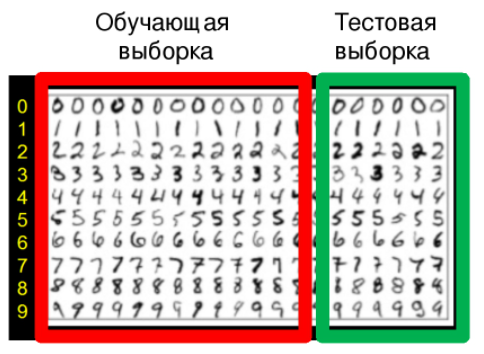

В TensorFlow, частью которого сейчас является Keras, есть тренировочные наборы данных, которые встроены в сам фреймворк. Загрузите датасет MNIST используя tensorflow\keras, либо загрузите его по ссылке : https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz

In [ ]:
# Если датасет загружен локально, то передайте в метод .load_data() параметр path="ваш путь к файлу"

(X_train_org, y_train_org), (X_test_org, y_test_org) = mnist.load_data() # Загрузка данных Mnist

In [ ]:
print(X_train_org.shape)
print(y_train_org.shape)
print(X_test_org.shape)
print(y_test_org.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
X_train_org[0].shape

(28, 28)

### Пример - выводим на экран картинку цифры из массива

In [ ]:
def show_image(n):
    plt.imshow(Image.fromarray(X_train_org[n]).convert('RGB')) #Отрисовка картинки
    plt.show() # Вывод картинки

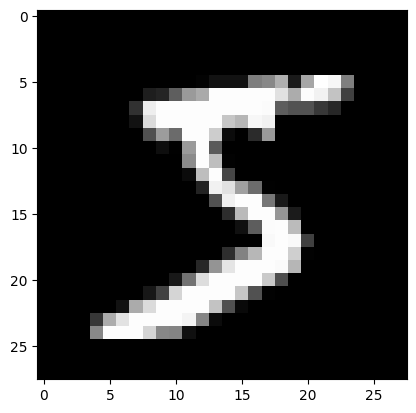

In [ ]:
show_image(0)

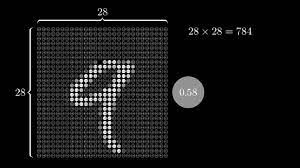

### Переводим данные в тип float
Данный тип (с плавающей точкой) необходим сетям Керас для обучения:

In [ ]:
X_train_2D = X_train_org.astype('float32')
X_test_2D = X_test_org.astype('float32')

### Нормализуем данные
В данном случае можно использовать простой вариант. Цветов всего 255, и меняются они через равные промежутки, поэтому удобно не применять скейлер, а поделить массив на 255. Вообще, данные стараются свести все к одинаковому диапазону, обычно 0...1. Это нужно для того, чтобы все признаки одинаково оценивались нейросетью, без значительного перекоса в сторону тех, которые больше и потому сеть им уделяет больше внимания.

In [ ]:
print(np.unique(X_train_2D)) # какие значения в массиве до нормализации
print(np.unique(X_test_2D))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

In [ ]:
X_train_2D = X_train_2D / 255 # делим на 255, чтобы диапазон был от 0 до 1
X_test_2D = X_test_2D / 255 # делим на 255, чтобы диапазон был от 0 до 1

In [ ]:
print(np.unique(X_train_2D)) # какие значения в массиве после нормализации
print(np.unique(X_test_2D))

[0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177 0.33333334 0.3372549  0.34117648 0.34509805 0.3490196

### Делаем из данных векторы вместо матриц

In [ ]:
X_train = X_train_2D.reshape(60000, 28, 28, 1)
X_test = X_test_2D.reshape(10000, 28, 28, 1)
print(X_train_2D.shape)
print(X_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [ ]:
def show_lin_image(n):
    plt.figure(figsize=(36, 12)) # задаем размеры всего рисунка
    plt.imshow(Image.fromarray(X_train[n].reshape(1,-1) * 255).convert('RGB')) #Отрисовка картинки
    plt.show() # Вывод картинки

### Переводим метки в формат One Hot Encoding (OHE)

При кодировании в OHE, вместо числа получаем вектор из всех нулей, кроме одной цифры - вместо нуля на той позиции (индексе), которой соответствует кодируемая цифра, стоит 1.

In [ ]:
# используйте модуль utils библиотеки keras, оттуда используйте метод to_categorical как в скринкасте
y_train = utils.to_categorical(y_train_org, 10)
y_test = utils.to_categorical(y_test_org, 10)

## Построение сверточной

Используем следующие слои:

- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество обучаемых фильтров (выходных каналов);
    - **kernel_size**: целое или пара целых чисел, определяющих размер сверточного окна(фильтра);
    - **padding**: padding="same" добавляем рамку из нулей вокруг исходной картинки, таким образом сохраняется размер исходной матрицы, padding='valid' выполняет прохождение фильтров только во внутренней области исходной матрицы, что приводит к поджатию ее размера;
    - **activation**: функция активации "relu", "tanh".
    - **input_shape**: размер исходного тензора (изображения).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - подвыборка - сжатие результата сверточного слоя для уменьшения количества информации - теряется часть информации о метоположении признака, но сохраняется информация о его наличии.
- [Flatten](https://keras.io/layers/core/#flatten) - векторизация тензора.
- [Dense](https://keras.io/layers/core/#dense) - полносвязный слой.
- [Dropout](https://keras.io/layers/core/#dropout) - регуляризация за счет обнуления части нейронов обученного слоя.

### Создаём модель Sequential (c помощью функции как в предыдущем задании)

**Sequential** - это последовательная модель, в которой слои нейронной сети укладываются последовательно, как слои в блинном пироге. (Можно взять архитектуру модели по аналогии со скринкастом)

In [ ]:
# Не забудьте определить входной размер матрицы img_shape=(28,28,1), при передаче его в первый сверточный слой
# в качестве параметра input_shape
# Далее в последующих слоях можно не указывать input_shape, т.к keras сделает все преобразования за вас
model = Sequential()

model.add(Conv2D(32, kernel_size = (5, 5), strides = (1, 1), padding = 'same', activation = 'relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size = (5, 5), strides = (1, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation = 'linear'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

model.summary() # Описание модели

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                        

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
my_model = model.fit(X_train, y_train, batch_size=256, epochs=5, validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
235/235 [==============================] - 145s 595ms/step - loss: 0.4748 - accuracy: 0.8883 - val_loss: 9.1017 - val_accuracy: 0.1135
Epoch 2/5
235/235 [==============================] - 130s 553ms/step - loss: 0.1319 - accuracy: 0.9625 - val_loss: 0.3941 - val_accuracy: 0.9004
Epoch 3/5
235/235 [==============================] - 128s 546ms/step - loss: 0.0935 - accuracy: 0.9731 - val_loss: 0.0476 - val_accuracy: 0.9885
Epoch 4/5
235/235 [==============================] - 130s 554ms/step - loss: 0.0754 - accuracy: 0.9787 - val_loss: 0.0940 - val_accuracy: 0.9824
Epoch 5/5
235/235 [==============================] - 139s 591ms/step - loss: 0.0605 - accuracy: 0.9823 - val_loss: 0.0500 - val_accuracy: 0.9912


#### Значения на тестовой и валидационной выборках

In [ ]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

313/313 [==============================] - 7s 24ms/step - loss: 0.0500 - accuracy: 0.9912


[0.04996558651328087, 0.9911999702453613]

#### Выводим график точности на обучающей и валидационной выборке


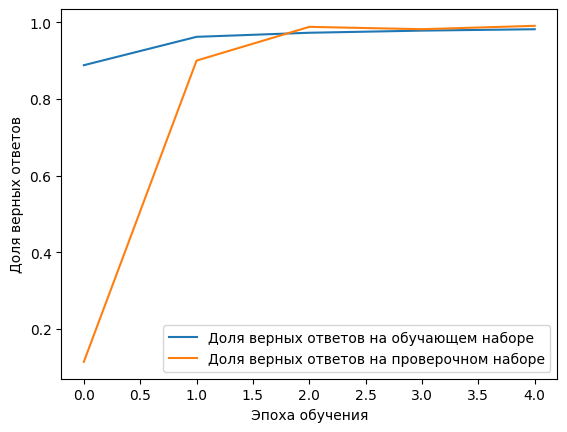

In [ ]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(my_model.history['accuracy'], label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(my_model.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

### Вектора предсказания классов и вероятностей приналежности к классам

In [ ]:
y_pred_test = model.predict(X_test)

313/313 [==============================] - 7s 24ms/step


In [ ]:
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_maxprob = np.max(y_pred_test, axis=1)

y_pred_test_classes[0], y_pred_test_maxprob[0]

(7, 0.99999994)

In [ ]:
number_classes = tuple(str(i) for i in range(10))

In [ ]:
y_test = np.argmax(y_test, axis=1)

##### Строим матрицу ошибок

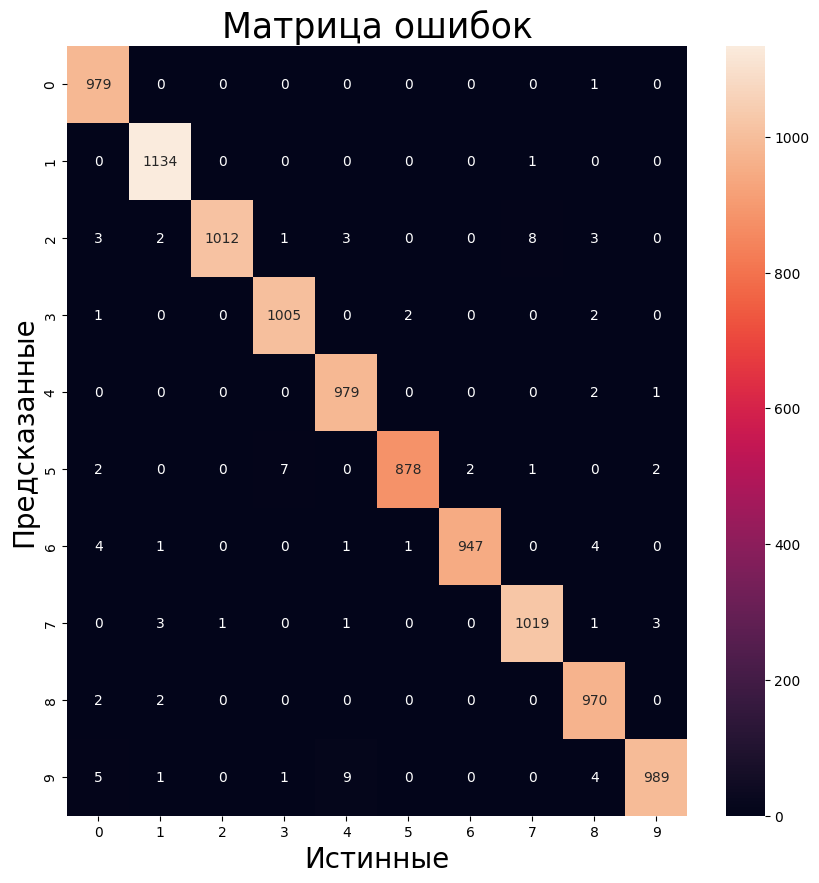

In [ ]:
plt.figure(figsize=(10,10))
cm = confusion_matrix(y_test, y_pred_test_classes)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=number_classes, yticklabels=number_classes)
plt.ylabel('Предсказанные', fontsize=20)
plt.xlabel('Истинные', fontsize=20)
plt.title('Матрица ошибок', fontsize=25)
plt.show()

**Сравним наши графики**
1) Полносвязная
![Полносвязная нейронная сеть](графики/Полносвязные.png)

2) Сверточная
![Сверточная нейронная сеть](графики/Сверточные.png)

<div style='border:solid blue 2px; padding: 20px'>
    
**Вывод:** 
    Наша модель лучше обучается при сверточном алгоритме

### 2. Задание ПРО (Не обязательно к выполнению). Используя GridSearch, оптимизируйте свёрточную нейронную сеть для наилучшей классификации. Также, подберите для неё наилучший по параметрам регуляризатор. Сделайте выводы.

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (5, 5), strides = (1, 1), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same'))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, kernel_size = (5, 5), strides = (1, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same'))
    model.add(Flatten())

    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = KerasClassifier(create_model, verbose=1)

<ipython-input-24-66902c6adf5e>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(create_model, verbose=1)


In [ ]:
# Если вы ловите подобную ошибку:'Adam' object has no attribute 'build', то нужно переустановить тензорфлоу на версию 2.11.0
# https://stackoverflow.com/questions/75088812/attributeerror-adam-object-has-no-attribute-build
# %pip install tensorflow==2.11.0
params={'batch_size':[24, 64, 128, 256, 512], 'nb_epoch':[5, 10, 15]}

gs = GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=1)
# now fit the dataset to the GridSearchCV object.
gs = gs.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
2500/2500 [==============================] - 89s 35ms/step - loss: 0.1939 - accuracy: 0.9380


In [ ]:
print(f"Наилучшие параметры: {gs.best_params_}")
print(f"Наилучшая точность: {gs.best_score_}")

Наилучшие параметры: {'batch_size': 24, 'nb_epoch': 15}
Наилучшая точность: 0.9815666675567627


<div class="alert alert-success">

# Вывод:
**GridSearch работал достаточно долго)... Однако мы нашли самую лучшую нейронную сеть с количеством образцов данных равным 24 (batch_size) и 15 эпохами обучения.**

## Литература


1. https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

2. https://creativecommons.org/licenses/by/4.0/

3. https://cs.stanford.edu/~acoates/stl10/

4. https://www.tensorflow.org/datasets/catalog/overview

5. https://keras.io/api/datasets/

6. https://en.wikipedia.org/wiki/Sensitivity_and_specificity

7. https://en.m.wikipedia.org/wiki/Batch_normalization#:~:text=Batch%20normalization%20(also%20known%20as,and%20Christian%20Szegedy%20in%202015.)

8. https://jmlr.org/papers/v15/srivastava14a.html

9. https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

10. https://neurohive.io/ru/osnovy-data-science/glubokaya-svertochnaja-nejronnaja-set/

11. https://ru.wikipedia.org/wiki/%D0%A1%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C

12. Автор: Max La - собственная работа, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=33394271

13. Y. LeCun, B. Boser, J. S. Denker, D. Henderson, R. E. Howard, W. Hubbard and L. D. Jackel: Backpropagation Applied to Handwritten Zip Code Recognition, Neural Computation, 1(4):541-551, Winter 1989.

14. https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/






